In [ ]:
%tensorflow_version 1.x
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Activation
from keras import optimizers
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import gc
from math import pi
import random
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Concatenate
from numpy import zeros
from numpy import ones
#from google.colab import drive

In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [ ]:
def load_data(pic):
  picure = 256
  a = np.linspace(-128, 127, picure)
  xv,yv = np.meshgrid( a , a )
  yv = yv*-1
  rho,theta = cart2pol( xv , yv )
  m =rho.max()*0.7
  rho = rho/m
  rho[rho>1]=np.nan
  X = np.zeros((pic, picure, picure))
  Y = np.zeros((pic, picure, picure))
  for i in range(0,pic,1):
    c =np.random.rand(1,32)/2
    c = c.round(6)
   
    phi =0*c[0,0]*1 \
        +c[0,1]* 2 * rho * np.sin(theta) \
        #+c[0,2]* 2 * rho * np.cos(theta)\
        #+c[0,3]*np.sqrt(6)*rho**2 * np.sin(2*theta)\
        #+c[0,4]*np.sqrt(3)*(2*rho**2 - 1)\
        #+c[0,5]*np.sqrt(6)*rho**2 * np.cos(2*theta)\
        #+c[0,6]*np.sqrt(8)*rho**3 * np.sin(3*theta)\
        #+c[0,7]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.sin(theta)\
        #+c[0,8]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.cos(theta)\
        #+c[0,9]*np.sqrt(8)*rho**3 * np.cos(3*theta)\
        #+c[0,10]*np.sqrt(10)*rho**4* np.sin(4*theta)\
 
    
    fring =np.cos(phi*pi/2)**2
    #fring2 = 4*np.cos((phi*pi/2)+(pi/4))**2
    #fring3 =fring / fring2
    fring[np.isnan(fring)] = 0
    phi[np.isnan(phi)] = 0
    X[i] = fring
    Y[i] = phi
    

  
 
    
  x_train = X.reshape(pic, 256,256,1)
  y_train = Y.reshape(pic, 256,256,1)
  del X
  del Y
  return (x_train, y_train)
#X_train, y_train = load_data(10)
#print(X_train.shape, y_train.shape)

In [ ]:
def build_generator(image_shape=(256,256,1)):

    inputs = Input((256, 256, 1))
    s = inputs

    c1 = Conv2D(32, (2, 2), strides=(1, 1), activation='tanh', kernel_initializer='he_normal', padding='same') (s)
    c1 = BatchNormalization(axis=3)(c1)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(32, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (c1)
    c1 = BatchNormalization(axis=3)(c1)
    p1 = MaxPooling2D((2, 2)) (c1)


    c2 = Conv2D(64, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (p1)
    c2 = BatchNormalization(axis=3)(c2)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(64, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (c2)
    c2 = BatchNormalization(axis=3)(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(128, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (p2)
    c3 = BatchNormalization(axis=3)(c3)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(128, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (c3)
    c3 = BatchNormalization(axis=3)(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(256, (2, 2),strides=(1, 1), activation='tanh', kernel_initializer='he_normal', padding='same') (p3)
    c4 = BatchNormalization(axis=3)(c4)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(256, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (c4)
    c4 = BatchNormalization(axis=3)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(512, (2, 2),strides=(1, 1), activation='tanh', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(512, (2, 2),strides=(1, 1), activation='tanh', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (u6)
    c6 = BatchNormalization(axis=3)(c6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(256, (2, 2),strides=(1, 1), activation='tanh', kernel_initializer='he_normal', padding='same') (c6)
    c6 = BatchNormalization(axis=3)(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization(axis=3)(c7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(128, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (c7)
    c7 = BatchNormalization(axis=3)(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization(axis=3)(c8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(64, (2, 2),strides=(1, 1), activation='tanh', kernel_initializer='he_normal', padding='same') (c8)
    c8 = BatchNormalization(axis=3)(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization(axis=3)(c9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(32, (2, 2), strides=(1, 1),activation='tanh', kernel_initializer='he_normal', padding='same') (c9)
    c9 = BatchNormalization(axis=3)(c9)

    outputs = Conv2D(1, (1, 1), activation='tanh') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.002),metrics=['accuracy'])
    return model

generator = build_generator()
generator.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 256, 256, 32) 160         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 256, 256, 32) 128         conv2d_51[0][0]                  
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 256, 256, 32) 0           batch_normalization_41[0][0]     
____________________________________________________________________________________________

In [ ]:
def build_discriminator(image_shape=(256,256,1)):
    
    
	  
    in_src_image = Input(shape=image_shape)
	  
    in_target_image = Input(shape=image_shape)
   	
    merged = Concatenate()([in_src_image, in_target_image])

    d = Conv2D(64, (4,4), strides=(2,2),  padding='same')(merged)
    d = LeakyReLU(alpha=0.2)(d)
	
    d = Conv2D(128, (4,4), strides=(2,2),  padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	
    d = Conv2D(256, (4,4), strides=(2,2), padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	
    d = Conv2D(512, (4,4), strides=(2,2),padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	
    d = Conv2D(512, (4,4), padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
	
    d = Conv2D(1, (4,4), padding='same')(d)
    patch_out = Activation('sigmoid')(d)

    model = Model([in_src_image, in_target_image], patch_out)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.002),metrics=['accuracy'])
    return model

image_shape =(256,256,1)
discriminator = build_discriminator(image_shape)
discriminator.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 256, 256, 2)  0           input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 128, 128, 64) 2112        concatenate_15[0][0]       

In [ ]:
def build_GAN(discriminator, generator):
    discriminator.trainable=False
    GAN_input = Input(shape=(256,256,1))
    x = generator(GAN_input)
    GAN_output= discriminator([x,GAN_input])
    GAN = Model(inputs=GAN_input, outputs=[GAN_output,x])
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.002),metrics=['accuracy'])
    return GAN

GAN = build_GAN(discriminator, generator)
GAN.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 256, 256, 1)  3845121     input_12[0][0]                   
__________________________________________________________________________________________________
model_8 (Model)                 (None, 16, 16, 1)    6964161     model_7[1][0]                    
                                                                 input_12[0][0]                   
Total params: 10,809,282
Trainable params: 3,841,281
Non-trainable params: 6,968,001
__________________________________________________________________________________________________


In [ ]:
def draw_images(generator, epoch, examples=25, dim=(5,5), figsize=(10,10)):
    '''
    X_train, y_train = load_data(pic=25)
    generated_images = generator.predict(X_train)
    generated_images = generated_images.reshape(25,256,256)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray')#interpolation='nearest'
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('Generated_images %d.png' %epoch)
    '''
    X_train, y_train = load_data(pic=1)
    generated_images = generator.predict(X_train)
    generated_images = generated_images.reshape(256,256)
    y_train = y_train.reshape(256,256)
    print(y_train.max())
    print(y_train.min())
    print(generated_images.max())
    print(generated_images.min())
    imshow(y_train)
    plt.show()
    imshow(generated_images)
    plt.show()

Round 1
Epoch 1/10
 - 12s - loss: 0.1051 - accuracy: 0.9630
Epoch 2/10
 - 12s - loss: 0.0046 - accuracy: 0.9997
Epoch 3/10
 - 12s - loss: 0.0043 - accuracy: 0.9989
Epoch 4/10
 - 12s - loss: 0.0050 - accuracy: 0.9985
Epoch 5/10
 - 12s - loss: 8.9233e-04 - accuracy: 1.0000
Epoch 6/10
 - 12s - loss: 2.9880e-04 - accuracy: 1.0000
Epoch 7/10
 - 12s - loss: 1.5564e-04 - accuracy: 1.0000
Epoch 8/10
 - 12s - loss: 8.9431e-05 - accuracy: 1.0000
Epoch 9/10
 - 12s - loss: 6.8198e-05 - accuracy: 1.0000
Epoch 10/10
 - 12s - loss: 9.2157e-05 - accuracy: 1.0000
Epoch 1/50
 - 38s - loss: 6.2501 - model_11_loss: 5.7096 - model_10_loss: 0.5017 - model_11_accuracy: 0.5602 - model_10_accuracy: 0.0318
Epoch 2/50
 - 30s - loss: 3.8214 - model_11_loss: 3.8357 - model_10_loss: -2.6331e-02 - model_11_accuracy: 0.5710 - model_10_accuracy: 0.0088
Epoch 3/50
 - 31s - loss: 3.4355 - model_11_loss: 3.6422 - model_10_loss: -2.0638e-01 - model_11_accuracy: 0.5710 - model_10_accuracy: 0.0080
Epoch 4/50
 - 30s - loss: 

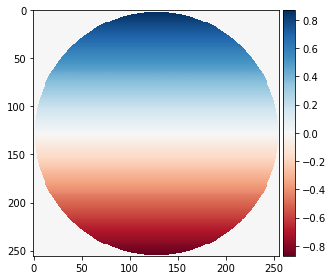

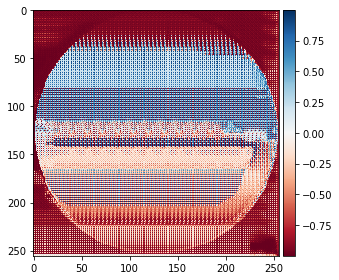

Round 2
Epoch 1/10
 - 13s - loss: 0.3770 - accuracy: 0.9585
Epoch 2/10


In [ ]:
def train_GAN(epochs=1, batch_size=8):
  pic=1000

  # Creating GAN
  generator= build_generator()
  discriminator= build_discriminator()
  GAN = build_GAN(discriminator, generator)

  
  for i in tqdm(range(1, epochs+1)):
        print("Round %d" %i)     # Generate fake images from random noiset
      #for _ in tqdm(range(batch_size)):
        X_train, y_train = load_data(pic)
        


        fake_images = generator.predict(X_train)
        real_images = y_train

      # Labels for fake and real images           
        label_fake = zeros((pic,16,16))
        label_fake = label_fake.reshape((pic,16,16,1))
        label_real = ones((pic,16,16))
        label_real = label_real.reshape((pic,16,16,1)) 

      # Concatenate fake and real images 
        inp = np.concatenate([X_train, X_train])
        X = np.concatenate([fake_images, real_images])
        y = np.concatenate([label_fake, label_real])
        for j in range(1, batch_size+1):
          #print("Epoch %d" %j)
 
 
      # Train the discriminator
          discriminator.trainable=True
          #discriminator.train_on_batch([inp,X], y)
          history = discriminator.fit([inp,X],y,
                  epochs=10, batch_size=32,verbose=2)
      # Train the generator/chained GAN model (with frozen weights in discriminator) 
          discriminator.trainable=False
          #GAN.train_on_batch(X_train, [label_real,y_train])
          history = GAN.fit(X_train, [label_real,y_train],
                  epochs=50, batch_size=32,verbose=2)
    # Draw generated images every 15 epoches     
        if i == 1 or i % 1 == 0:
          draw_images(generator, i)
train_GAN(epochs=40,batch_size=1)